# R1212のenergy計算

In [2]:
%cd ~/desktop/RNA/casp16
pdb_dir="./datasets/casp16/R1212/pdb"

!ls {pdb_dir}/*pdb | wc -l

# !python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir}

/Users/sumishunsuke/Desktop/RNA/casp16
    1000
['S_000668.pdb', 'S_000654.pdb', 'S_000132.pdb', 'S_000126.pdb']
Traceback (most recent call last):
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 82, in <module>
    main()
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 65, in main
    res_rnabriq = RNA_BRiQ.RNA_BRiQ_eval_batch(args.pdb_dir, args.out_dir)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./src/score/RNA_BRiQ.py", line 65, in RNA_BRiQ_eval_batch
    with open(os.path.join(out_file, f), "r") as f:
                                     ^
UnboundLocalError: cannot access local variable 'f' where it is not associated with a value


In [5]:
import os

out_files = [f for f in os.listdir(pdb_dir) if f.endswith(".briq.out")]
print(len(out_files))

1000


# エネルギー書き出し

In [7]:
out_files = !ls {pdb_dir}/*briq.out

pdb_energy = {}
for out in out_files:
    with open(out) as fh: 
        lines = fh.readlines()
    energies = float(lines[-1].strip().replace("Energy: ", ""))
    basename = out.split("/")[-1].replace(".briq.out", "")
    pdb_energy[basename] = energies


pdb_energy["S_000001"]

import pandas as pd
df_briq = pd.DataFrame(pdb_energy.items(), columns=["pdb", "BRiQscore"])
print(df_briq.shape)
df_briq.head(3)

(1000, 2)


,pdb,BRiQscore
0,S_000001,-162.548
1,S_000002,-131.564
2,S_000003,-98.938


In [10]:
df_farfar = pd.read_csv(f"{pdb_dir}/R1212_FARFAR2_scores.csv")
df_farfar = df_farfar[["score", "description"]]
df_farfar.columns = ["FARFARscore", "pdb"]
df_farfar.head(3)

df = pd.merge(df_briq, df_farfar, on="pdb")
df.head(3)
# df.to_csv(f"{pdb_dir}/R1211_scores.csv", index=False)

,pdb,BRiQscore,FARFARscore
0,S_000001,-162.548,-199.691
1,S_000002,-131.564,-253.164
2,S_000003,-98.938,-60.141


# 可視化

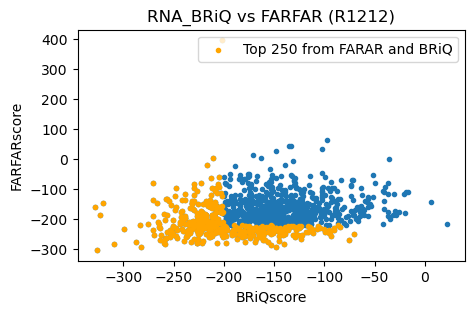

(399, 3)


In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_scores = pd.read_csv(f"{pdb_dir}/R1212_scores.csv")



n_take = 250
df_briq_top = df_scores.sort_values("BRiQscore", ascending=True).head(n_take)
df_farfar_top = df_scores.sort_values("FARFARscore", ascending=True).head(n_take)
df_both_top = pd.concat([df_briq_top, df_farfar_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df_scores["BRiQscore"], df_scores["FARFARscore"], marker=".")
plt.scatter(df_both_top["BRiQscore"], df_both_top["FARFARscore"], marker=".", color="orange", label=f"Top {n_take} from FARAR and BRiQ")
plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("FARFARscore")
plt.title("RNA_BRiQ vs FARFAR (R1212)")
plt.show()
print(df_both_top.shape)

In [15]:
df_both_top.head()

,pdb,BRiQscore,FARFARscore
426,S_000427,-327.960,-162.641
127,S_000128,-326.559,-305.268
972,S_000973,-322.846,-186.780
80,S_000081,-320.629,-147.526
780,S_000781,-308.728,-285.481


In [21]:
# cp selected pdb to new dir    
!mkdir -p ./datasets/casp16/R1212/pdb_selected
for pdb in df_both_top["pdb"]:
    !cp {pdb_dir}/{pdb}.pdb ./datasets/casp16/R1212/pdb_selected

# R1212の距離計算

In [22]:
pdb_sele_dir="./datasets/casp16/R1212/pdb_selected"
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [23]:
%cd ~/desktop/RNA/casp16
!time python scripts/calc_rmsd.py --pdb_dir {pdb_sele_dir} --cpu 8

/Users/sumishunsuke/Desktop/RNA/casp16
['S_000002.pdb', 'S_000005.pdb', 'S_000007.pdb', 'S_000009.pdb', 'S_000010.pdb']
Number of pdb files: 399
Calculating RMSD matrix 399x399 using 8 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 40th pdb file
Calculating RMSD for 20th pdb file
Calculating RMSD for 50th pdb file
Calculating RMSD for 10th pdb file
Calculating RMSD for 30th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 110th pdb file
Calculating RMSD for 70th pdb file
Calculating RMSD for 80th pdb file
Calculating RMSD for 90th pdb file
Calculating RMSD for 60th pdb file
Calculating RMSD for 190th pdb file
Calculating RMSD for 120th pdb file
Calculating RMSD for 180th pdb file
Calculating RMSD for 130th pdb file
Calculating RMSD for 170th pdb file
Calculating RMSD for 140th pdb file
Calculating RMSD for 160th pdb file
Calculating RMSD for 150th pdb file
Calculating RMSD for 200th pdb file
Calculating RMSD for 300th pdb file
Calculating RMSD for 330th pd

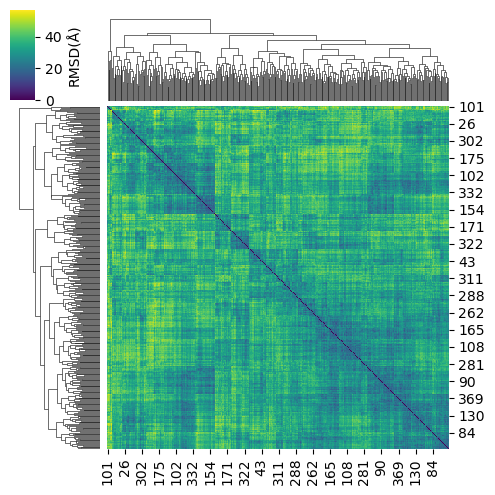

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{pdb_sele_dir}/rmsd_matrix_sorted_id.npy")
g = sns.clustermap(rmsd, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})
# plt.savefig(f"{pdb_sele_dir}/rmsd_clustermap.png", dpi = 300)

# MDS, DBSCAN

In [25]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

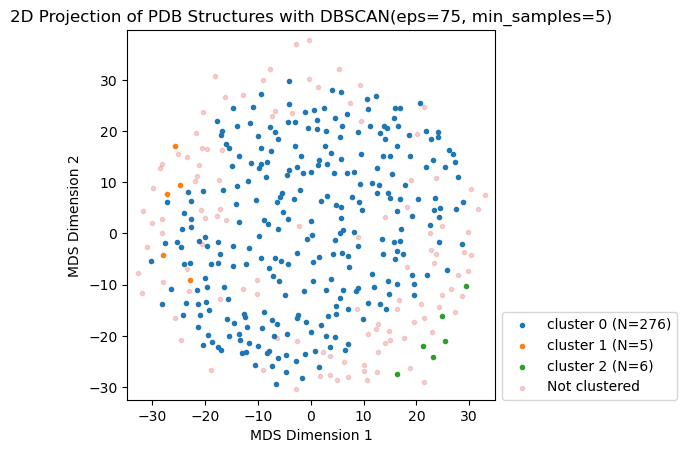

In [64]:
from sklearn.cluster import DBSCAN

eps = 75
min_samples = 5
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.subplots_adjust(right=0.7)
# plt.savefig(f"{pdb_dir}/rmsd_mds_dbscan.png", dpi = 300)
plt.show()


In [51]:
df_scores.head(3)

pdb_selected = !ls ./datasets/casp16/R1212/pdb_selected/*pdb
pdb_selected = [os.path.basename(p).replace(".pdb", "") for p in pdb_selected]
df_scores_selected = df_scores[df_scores["pdb"].isin(pdb_selected)]
print(df_scores_selected.shape)
df_scores_selected.head(3)

(399, 3)


,pdb,BRiQscore,FARFARscore
1,S_000002,-131.564,-253.164
4,S_000005,-199.570,-254.515
6,S_000007,-257.244,-265.568


In [52]:
df_scores_selected["cluster"] = clustering.labels_
df_scores_selected.to_csv(f"{pdb_sele_dir}/R1212_scores_clustered.csv", index=False)
df_scores_selected = pd.read_csv(f"{pdb_sele_dir}/R1212_scores_clustered.csv")
df_scores_selected.head(3)

,pdb,BRiQscore,FARFARscore,cluster
0,S_000002,-131.564,-253.164,0
1,S_000005,-199.570,-254.515,0
2,S_000007,-257.244,-265.568,0


In [62]:
for c in [0,2]:
    n = sum(df_scores_selected["cluster"] == c)
    print(f"Cluster {c} (N={n})")
    print(df_scores_selected[df_scores_selected["cluster"] == c].sort_values("BRiQscore").head(5))
    print("**"*20)
    print(df_scores_selected[df_scores_selected["cluster"] == c].sort_values("FARFARscore").head(5))
    print("**"*20)

Cluster 0 (N=276)
          pdb  BRiQscore  FARFARscore  cluster
182  S_000427   -327.960     -162.641        0
60   S_000128   -326.559     -305.268        0
286  S_000701   -299.242     -234.350        0
298  S_000738   -283.643     -221.595        0
13   S_000031   -282.051     -293.474        0
****************************************
          pdb  BRiQscore  FARFARscore  cluster
60   S_000128   -326.559     -305.268        0
245  S_000586   -147.963     -294.555        0
13   S_000031   -282.051     -293.474        0
58   S_000124   -153.197     -288.618        0
268  S_000656   -258.243     -285.094        0
****************************************
Cluster 2 (N=6)
          pdb  BRiQscore  FARFARscore  cluster
319  S_000781   -308.728     -285.481        2
96   S_000236   -233.629     -218.991        2
199  S_000457   -231.647     -152.689        2
131  S_000321   -220.827     -275.958        2
216  S_000503   -204.480     -235.077        2
**************************************

Text(0, 0.5, 'FARFARscore')

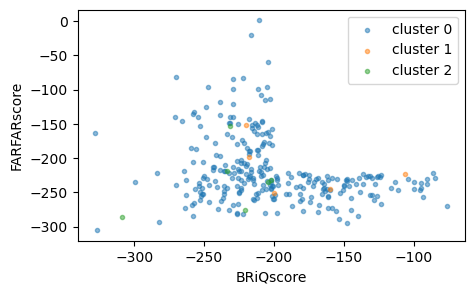

In [61]:
# scatter for each cluster
# hist2d

plt.figure(figsize=(5,3))
for c in set(df_scores_selected["cluster"]):
    if c == -1: continue
    plt.scatter(df_scores_selected[df_scores_selected["cluster"] == c]["BRiQscore"], df_scores_selected[df_scores_selected["cluster"] == c]["FARFARscore"], label=f"cluster {c}", marker=".", alpha=0.5)
    

plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("FARFARscore")

# リファレンス(8SP9)に対するRMSD

In [92]:
df_rmsd_to_ref = pd.read_csv(f"{pdb_dir}/RMSD_R1211_8SP9.csv", header=None)
df_rmsd_to_ref["pdb"] = df_rmsd_to_ref[0].apply(lambda x: x.split("/")[-1].replace(".pdb", ""))
df_rmsd_to_ref.drop(0, axis=1, inplace=True)
df_rmsd_to_ref.columns = ["RMSD_to_ref", "pdb"]
df_rmsd_to_ref

,RMSD_to_ref,pdb
0,21.51,S_000001
1,13.51,S_000002
2,21.76,S_000003
3,23.35,S_000004
4,22.51,S_000005
...,...,...
995,11.01,S_000996
996,26.62,S_000997
997,8.52,S_000998
998,28.23,S_000999


In [93]:
# merge with df_scores
df_scores = pd.merge(df_scores, df_rmsd_to_ref, on="pdb")
df_scores.head(3)

,pdb,BRiQscore,FARFARscore,cluster,RMSD_to_ref
0,S_000001,-229.230,-104.245,0,21.51
1,S_000002,-170.377,-131.065,1,13.51
2,S_000003,-183.205,-116.796,0,21.76


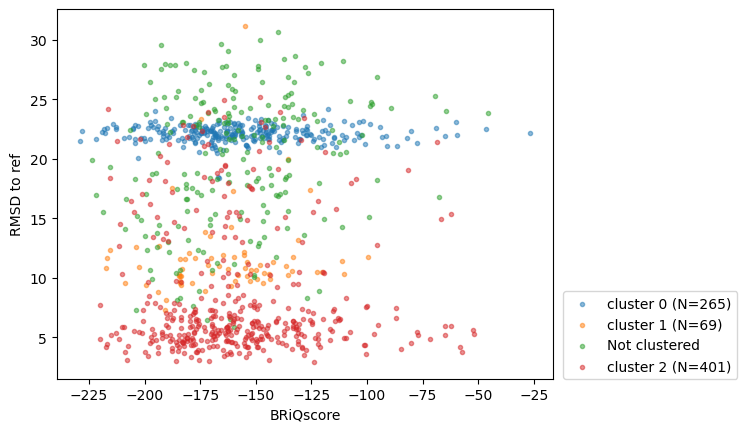

In [103]:
# scatter for each cluster

for c in df_scores["cluster"].unique():
    n = sum(df_scores["cluster"] == c)
    if n < 20: continue
    if c == -1: label = "Not clustered"
    else: label = f"cluster {c} (N={n})"
    plt.scatter(
        df_scores[df_scores["cluster"] == c]["BRiQscore"],
        df_scores[df_scores["cluster"] == c]["RMSD_to_ref"], 
        label=label, marker=".", alpha=0.5
        )
    

plt.xlabel("BRiQscore")
plt.ylabel("RMSD to ref")
plt.legend(loc = (1.02,0))


In [108]:
# check the to of a cluster
c = 0
for c in [0,1,2]:
    print(f"Cluster {c}(N={sum(df_scores['cluster'] == c)})")
    print(df_scores[df_scores["cluster"] == c].sort_values("RMSD_to_ref").head(5))
    print("**"*20)

Cluster 0(N=265)
          pdb  BRiQscore  FARFARscore  cluster  RMSD_to_ref
987  S_000988   -166.637     -116.452        0        18.36
797  S_000798   -167.118      -58.213        0        18.50
9    S_000010   -203.109     -160.402        0        20.06
325  S_000326   -167.537      -95.355        0        20.49
101  S_000102   -175.337      -66.716        0        20.57
****************************************
Cluster 1(N=69)
          pdb  BRiQscore  FARFARscore  cluster  RMSD_to_ref
163  S_000164   -190.890     -121.460        1         7.28
149  S_000150   -190.309      -97.174        1         8.12
150  S_000151   -194.005      -43.700        1         8.81
978  S_000979   -172.780     -120.989        1         8.85
168  S_000169   -161.195     -126.578        1         9.27
****************************************
Cluster 2(N=401)
          pdb  BRiQscore  FARFARscore  cluster  RMSD_to_ref
844  S_000845   -123.928      -78.240        2         2.93
271  S_000272   -171.256    

# cluster 2にfocusした解析

Text(0, 0.5, 'Count')

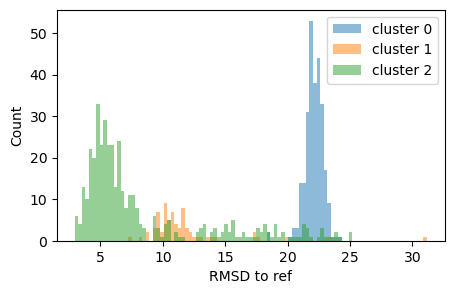

In [165]:
# histo of RMSD in each cluster
# use same bins 

bins = np.linspace(
    min(df_scores["RMSD_to_ref"]),
    max(df_scores["RMSD_to_ref"]),
    100
    )

plt.figure(figsize=(5,3))
for c in [0,1,2]:
    plt.hist(df_scores[df_scores["cluster"] == c]["RMSD_to_ref"], bins=bins, alpha=0.5, label=f"cluster {c}")
plt.legend()
plt.xlabel("RMSD to ref")
plt.ylabel("Count")

In [178]:
df_cluster2_10 = df_scores[df_scores["cluster"] == 2][df_scores["RMSD_to_ref"] < 10]
idx_cluster2_10 = df_cluster2_10.index.tolist()
idx_cluster2_10[:5]

[6, 7, 10, 12, 14]

In [179]:
rmsd = np.load(f"{pdb_dir}/rmsd_matrix_sorted_id.npy")
rmsd_cluster2 = rmsd[idx_cluster2_10][:, idx_cluster2_10]
rmsd_cluster2.shape

(309, 309)

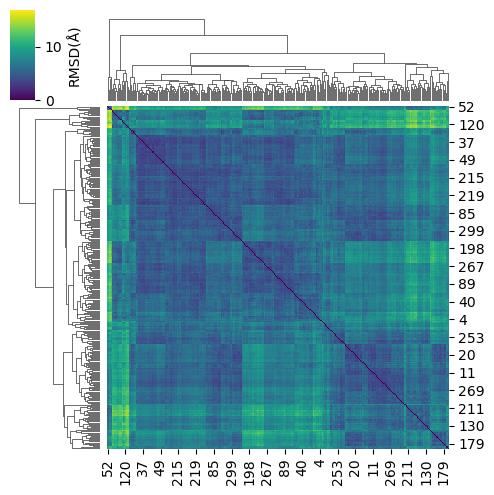

In [180]:
g = sns.clustermap(rmsd_cluster2, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})


# MDS for cluster 2

In [169]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd_cluster2)

Text(0.5, 1.0, 'MDS of cluster 2 (<10Å)\n with DBSCAN(eps=15, min_samples=5)')

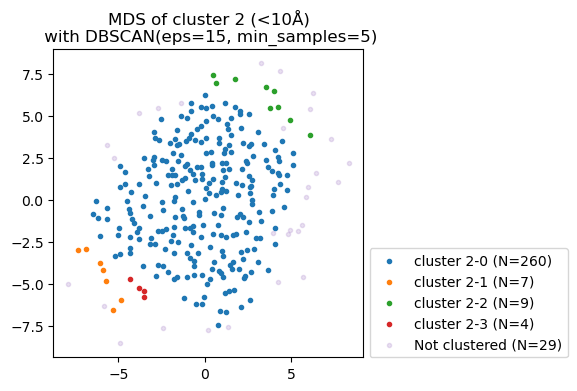

In [186]:
from sklearn.cluster import DBSCAN
eps = 15
min_samples = 5
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd_cluster2)

plt.figure(figsize=(4,4))

for c in set(clustering.labels_):
    if c == -1: 
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"Not clustered (N={n})", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster 2-{c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.title(f'MDS of cluster 2 (<10Å)\n with DBSCAN(eps={eps}, min_samples={min_samples})')


In [195]:

df_cluster2_10["subcluster"] = clustering.labels_   
for subc in [0]:
    n = sum(df_cluster2_10["subcluster"] == subc)
    print(f"Subcluster 2-{subc} (N={n})")
    print(df_cluster2_10[df_cluster2_10["subcluster"] == subc].sort_values("RMSD_to_ref", ascending=True).head(5))
    print(df_cluster2_10[df_cluster2_10["subcluster"] == subc].sort_values("BRiQscore", ascending=True).head(5))

    print("**"*20)



Subcluster 2-0 (N=260)
          pdb  BRiQscore  FARFARscore  cluster  RMSD_to_ref  subcluster
844  S_000845   -123.928      -78.240        2         2.93           0
271  S_000272   -171.256      -82.664        2         3.01           0
798  S_000799   -143.962      -74.066        2         3.05           0
783  S_000784   -175.458      -34.960        2         3.06           0
494  S_000495   -207.784     -143.095        2         3.07           0
          pdb  BRiQscore  FARFARscore  cluster  RMSD_to_ref  subcluster
588  S_000589   -220.232     -135.150        2         4.86           0
492  S_000493   -219.890     -141.742        2         7.73           0
887  S_000888   -217.531      -67.466        2         4.17           0
170  S_000171   -216.894     -130.785        2         4.42           0
618  S_000619   -214.994     -141.979        2         5.23           0
****************************************
